In [1]:
%matplotlib inline

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import seaborn as sns
plt.ion()   # interactive mode

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

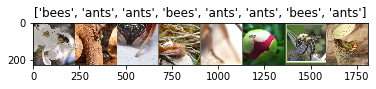

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses=[]
    val_losses=[]
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                #print(inputs.size())
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            print('{} Rajat Best_Acc: {:.4f} Epoch_Acc: {:.4f}'.format(
                phase, best_acc, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            #collect losses
            if phase=='train':
                train_losses.append(epoch_loss)
            if phase=='val':
                val_losses.append(epoch_loss)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,train_losses,val_losses

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            print("modi",inputs.size())
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
import pandas as pd
def plot_losses(train_loss,val_loss):
    df = pd.DataFrame(list(zip([i for i in range(0,len(train_losses))],train_loss,val_loss)), 
               columns =['epoch', 'train_loss','val_loss']) 
    list_data=[df.train_loss,df.val_loss]
    plots=sns.lineplot(data=list_data)
    return plots

In [7]:
def dump_output(model,train_loss,val_loss,experiment_name):
    model_dump_path=experiment_name+'.pt'
    torch.save(model.state_dict(),model_dump_path)
    csv_dump_path=experiment_name+'.csv'
    df = pd.DataFrame(list(zip(train_loss,val_loss)), 
           columns =[ 'train_loss','val_loss'])
    df.to_csv(csv_dump_path)
    list_data=[df.train_loss,df.val_loss]
    plot_dump_path=experiment_name+'.png'
    plots=sns.lineplot(data=list_data)
    fig=plots.get_figure()
    fig.savefig(plot_dump_path)

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_conv,train_losses,val_losses = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,
                       num_epochs=300)
dump_output(model_conv,train_losses[0:50],val_losses[0:50],'with-pretrained-resnet18_lrscheduler_lastlayer')

Epoch 0/299
----------
train Loss: 0.5518 Acc: 0.7049
train Rajat Best_Acc: 0.0000 Epoch_Acc: 0.7049
val Loss: 0.3631 Acc: 0.8366
val Rajat Best_Acc: 0.0000 Epoch_Acc: 0.8366

Epoch 1/299
----------
train Loss: 0.3339 Acc: 0.8730
train Rajat Best_Acc: 0.8366 Epoch_Acc: 0.8730
val Loss: 0.2109 Acc: 0.9542
val Rajat Best_Acc: 0.8366 Epoch_Acc: 0.9542

Epoch 2/299
----------
train Loss: 0.3653 Acc: 0.8402
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.8402
val Loss: 0.1984 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 3/299
----------
train Loss: 0.3148 Acc: 0.8730
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.8730
val Loss: 0.1999 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 4/299
----------
train Loss: 0.2830 Acc: 0.9139
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9139
val Loss: 0.1745 Acc: 0.9673
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9673

Epoch 5/299
----------
train Loss: 0.2697 Acc: 0.8689
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.8689
val Loss: 0.1658 Ac

val Loss: 0.1799 Acc: 0.9477
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9477

Epoch 47/299
----------
train Loss: 0.2503 Acc: 0.9139
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9139
val Loss: 0.1570 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 48/299
----------
train Loss: 0.2215 Acc: 0.8975
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8975
val Loss: 0.1529 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 49/299
----------
train Loss: 0.2230 Acc: 0.9016
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9016
val Loss: 0.1674 Acc: 0.9477
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9477

Epoch 50/299
----------
train Loss: 0.2439 Acc: 0.8770
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8770
val Loss: 0.1621 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 51/299
----------
train Loss: 0.2834 Acc: 0.8770
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.8770
val Loss: 0.1569 Acc: 0.9477
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9477

Epoch 52/299
----------
train Loss: 0.29

In [ ]:
model_conv = torchvision.models.resnet34(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_conv,train_losses,val_losses = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,
                       num_epochs=300)
dump_output(model_conv,train_losses[0:50],val_losses[0:50],'with-pretrained-resnet34_lrscheduler_lastlayer')

In [9]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_conv,train_losses,val_losses = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,
                       num_epochs=300)
dump_output(model_conv,train_losses[0:50],val_losses[0:50],'with-pretrained-resnet50_lrscheduler_lastlayer')

Epoch 0/299
----------
train Loss: 0.5865 Acc: 0.6434
train Rajat Best_Acc: 0.0000 Epoch_Acc: 0.6434
val Loss: 0.4696 Acc: 0.7582
val Rajat Best_Acc: 0.0000 Epoch_Acc: 0.7582

Epoch 1/299
----------
train Loss: 0.3424 Acc: 0.8525
train Rajat Best_Acc: 0.7582 Epoch_Acc: 0.8525
val Loss: 0.1935 Acc: 0.9477
val Rajat Best_Acc: 0.7582 Epoch_Acc: 0.9477

Epoch 2/299
----------
train Loss: 0.3391 Acc: 0.8484
train Rajat Best_Acc: 0.9477 Epoch_Acc: 0.8484
val Loss: 0.1773 Acc: 0.9412
val Rajat Best_Acc: 0.9477 Epoch_Acc: 0.9412

Epoch 3/299
----------
train Loss: 0.2627 Acc: 0.8975
train Rajat Best_Acc: 0.9477 Epoch_Acc: 0.8975
val Loss: 0.1736 Acc: 0.9412
val Rajat Best_Acc: 0.9477 Epoch_Acc: 0.9412

Epoch 4/299
----------
train Loss: 0.3029 Acc: 0.8648
train Rajat Best_Acc: 0.9477 Epoch_Acc: 0.8648
val Loss: 0.2081 Acc: 0.9412
val Rajat Best_Acc: 0.9477 Epoch_Acc: 0.9412

Epoch 5/299
----------
train Loss: 0.2341 Acc: 0.9057
train Rajat Best_Acc: 0.9477 Epoch_Acc: 0.9057
val Loss: 0.1736 Ac

KeyboardInterrupt: 

Epoch 0/299
----------
train Loss: 0.5424 Acc: 0.6885
train Rajat Best_Acc: 0.0000 Epoch_Acc: 0.6885
val Loss: 0.2711 Acc: 0.8954
val Rajat Best_Acc: 0.0000 Epoch_Acc: 0.8954

Epoch 1/299
----------
train Loss: 0.3108 Acc: 0.8770
train Rajat Best_Acc: 0.8954 Epoch_Acc: 0.8770
val Loss: 0.1992 Acc: 0.9216
val Rajat Best_Acc: 0.8954 Epoch_Acc: 0.9216

Epoch 2/299
----------
train Loss: 0.2225 Acc: 0.9385
train Rajat Best_Acc: 0.9216 Epoch_Acc: 0.9385
val Loss: 0.1775 Acc: 0.9281
val Rajat Best_Acc: 0.9216 Epoch_Acc: 0.9281

Epoch 3/299
----------
train Loss: 0.2838 Acc: 0.8934
train Rajat Best_Acc: 0.9281 Epoch_Acc: 0.8934
val Loss: 0.1507 Acc: 0.9542
val Rajat Best_Acc: 0.9281 Epoch_Acc: 0.9542

Epoch 4/299
----------
train Loss: 0.2076 Acc: 0.9303
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9303
val Loss: 0.1983 Acc: 0.9150
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9150

Epoch 5/299
----------
train Loss: 0.2152 Acc: 0.9180
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9180
val Loss: 0.1403 Ac

val Loss: 0.1362 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 47/299
----------
train Loss: 0.2270 Acc: 0.9098
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9098
val Loss: 0.1196 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 48/299
----------
train Loss: 0.1689 Acc: 0.9385
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9385
val Loss: 0.1359 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 49/299
----------
train Loss: 0.1564 Acc: 0.9590
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9590
val Loss: 0.1346 Acc: 0.9477
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9477

Epoch 50/299
----------
train Loss: 0.2419 Acc: 0.8893
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.8893
val Loss: 0.1263 Acc: 0.9542
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9542

Epoch 51/299
----------
train Loss: 0.1449 Acc: 0.9344
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9344
val Loss: 0.1457 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 52/299
----------
train Loss: 0.14

train Loss: 0.1705 Acc: 0.9467
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9467
val Loss: 0.1319 Acc: 0.9412
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9412

Epoch 94/299
----------
train Loss: 0.2659 Acc: 0.8852
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.8852
val Loss: 0.1404 Acc: 0.9346
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9346

Epoch 95/299
----------
train Loss: 0.1964 Acc: 0.9262
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9262
val Loss: 0.1472 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 96/299
----------
train Loss: 0.1732 Acc: 0.9344
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9344
val Loss: 0.1303 Acc: 0.9346
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9346

Epoch 97/299
----------
train Loss: 0.1937 Acc: 0.9221
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9221
val Loss: 0.1378 Acc: 0.9346
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9346

Epoch 98/299
----------
train Loss: 0.1594 Acc: 0.9467
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9467
val Loss: 0.1374 Acc: 0.9412
val Raja

val Loss: 0.1473 Acc: 0.9412
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9412

Epoch 140/299
----------
train Loss: 0.1586 Acc: 0.9467
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9467
val Loss: 0.1421 Acc: 0.9346
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9346

Epoch 141/299
----------
train Loss: 0.2169 Acc: 0.9016
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9016
val Loss: 0.1301 Acc: 0.9542
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9542

Epoch 142/299
----------
train Loss: 0.2193 Acc: 0.9139
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9139
val Loss: 0.1459 Acc: 0.9542
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9542

Epoch 143/299
----------
train Loss: 0.2543 Acc: 0.8811
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.8811
val Loss: 0.1345 Acc: 0.9346
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9346

Epoch 144/299
----------
train Loss: 0.1553 Acc: 0.9426
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9426
val Loss: 0.1466 Acc: 0.9412
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9412

Epoch 145/299
----------
train Loss

train Loss: 0.2013 Acc: 0.9139
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9139
val Loss: 0.1525 Acc: 0.9477
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9477

Epoch 187/299
----------
train Loss: 0.2106 Acc: 0.9180
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9180
val Loss: 0.1386 Acc: 0.9477
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9477

Epoch 188/299
----------
train Loss: 0.1826 Acc: 0.9385
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9385
val Loss: 0.1335 Acc: 0.9412
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9412

Epoch 189/299
----------
train Loss: 0.2011 Acc: 0.9098
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9098
val Loss: 0.1238 Acc: 0.9412
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9412

Epoch 190/299
----------
train Loss: 0.2062 Acc: 0.9098
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9098
val Loss: 0.1304 Acc: 0.9346
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9346

Epoch 191/299
----------
train Loss: 0.1307 Acc: 0.9713
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9713
val Loss: 0.1337 Acc: 0.9346
val

val Loss: 0.1396 Acc: 0.9346
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9346

Epoch 233/299
----------
train Loss: 0.1746 Acc: 0.9262
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9262
val Loss: 0.1408 Acc: 0.9542
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9542

Epoch 234/299
----------
train Loss: 0.2166 Acc: 0.9221
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9221
val Loss: 0.1396 Acc: 0.9542
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9542

Epoch 235/299
----------
train Loss: 0.1818 Acc: 0.9262
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9262
val Loss: 0.1465 Acc: 0.9346
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9346

Epoch 236/299
----------
train Loss: 0.1590 Acc: 0.9508
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9508
val Loss: 0.1367 Acc: 0.9412
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9412

Epoch 237/299
----------
train Loss: 0.1746 Acc: 0.9344
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9344
val Loss: 0.1344 Acc: 0.9412
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9412

Epoch 238/299
----------
train Loss

train Loss: 0.2190 Acc: 0.9098
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9098
val Loss: 0.1463 Acc: 0.9346
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9346

Epoch 280/299
----------
train Loss: 0.1928 Acc: 0.9344
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9344
val Loss: 0.1323 Acc: 0.9477
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9477

Epoch 281/299
----------
train Loss: 0.1743 Acc: 0.9385
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9385
val Loss: 0.1308 Acc: 0.9477
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9477

Epoch 282/299
----------
train Loss: 0.2360 Acc: 0.8975
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.8975
val Loss: 0.1471 Acc: 0.9477
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9477

Epoch 283/299
----------
train Loss: 0.1909 Acc: 0.9098
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9098
val Loss: 0.1553 Acc: 0.9281
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9281

Epoch 284/299
----------
train Loss: 0.2414 Acc: 0.8770
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.8770
val Loss: 0.1409 Acc: 0.9412
val

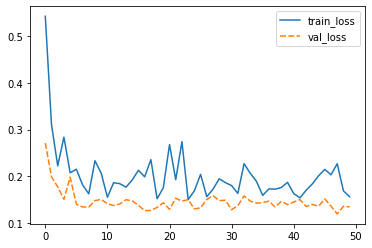

In [10]:
model_conv = torchvision.models.resnet101(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_conv,train_losses,val_losses = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,
                       num_epochs=300)
dump_output(model_conv,train_losses[0:50],val_losses[0:50],'with-pretrained-resnet101_lrscheduler_lastlayer')

Epoch 0/299
----------
train Loss: 0.6275 Acc: 0.6230
train Rajat Best_Acc: 0.0000 Epoch_Acc: 0.6230
val Loss: 0.3241 Acc: 0.8497
val Rajat Best_Acc: 0.0000 Epoch_Acc: 0.8497

Epoch 1/299
----------
train Loss: 0.3070 Acc: 0.8566
train Rajat Best_Acc: 0.8497 Epoch_Acc: 0.8566
val Loss: 0.2428 Acc: 0.9085
val Rajat Best_Acc: 0.8497 Epoch_Acc: 0.9085

Epoch 2/299
----------
train Loss: 0.2820 Acc: 0.8689
train Rajat Best_Acc: 0.9085 Epoch_Acc: 0.8689
val Loss: 0.1434 Acc: 0.9542
val Rajat Best_Acc: 0.9085 Epoch_Acc: 0.9542

Epoch 3/299
----------
train Loss: 0.2793 Acc: 0.8730
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.8730
val Loss: 0.1515 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 4/299
----------
train Loss: 0.3001 Acc: 0.8689
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.8689
val Loss: 0.1184 Acc: 0.9542
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9542

Epoch 5/299
----------
train Loss: 0.2807 Acc: 0.8730
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.8730
val Loss: 0.1619 Ac

val Loss: 0.0975 Acc: 0.9739
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9739

Epoch 47/299
----------
train Loss: 0.2838 Acc: 0.8689
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.8689
val Loss: 0.1006 Acc: 0.9739
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9739

Epoch 48/299
----------
train Loss: 0.1582 Acc: 0.9385
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9385
val Loss: 0.1029 Acc: 0.9739
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9739

Epoch 49/299
----------
train Loss: 0.1783 Acc: 0.9303
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9303
val Loss: 0.0962 Acc: 0.9608
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9608

Epoch 50/299
----------
train Loss: 0.1730 Acc: 0.9262
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9262
val Loss: 0.1030 Acc: 0.9608
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9608

Epoch 51/299
----------
train Loss: 0.2492 Acc: 0.8893
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.8893
val Loss: 0.1052 Acc: 0.9542
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9542

Epoch 52/299
----------
train Loss: 0.22

train Loss: 0.1575 Acc: 0.9426
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9426
val Loss: 0.1060 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 94/299
----------
train Loss: 0.1724 Acc: 0.9426
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9426
val Loss: 0.0982 Acc: 0.9608
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9608

Epoch 95/299
----------
train Loss: 0.2140 Acc: 0.9016
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9016
val Loss: 0.0975 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 96/299
----------
train Loss: 0.2081 Acc: 0.9303
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9303
val Loss: 0.1000 Acc: 0.9608
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9608

Epoch 97/299
----------
train Loss: 0.2042 Acc: 0.9098
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9098
val Loss: 0.1210 Acc: 0.9542
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9542

Epoch 98/299
----------
train Loss: 0.1614 Acc: 0.9385
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9385
val Loss: 0.1032 Acc: 0.9608
val Raja

val Loss: 0.1022 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 140/299
----------
train Loss: 0.2608 Acc: 0.8934
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.8934
val Loss: 0.1031 Acc: 0.9608
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9608

Epoch 141/299
----------
train Loss: 0.1894 Acc: 0.9344
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9344
val Loss: 0.1000 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 142/299
----------
train Loss: 0.1417 Acc: 0.9385
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9385
val Loss: 0.0990 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 143/299
----------
train Loss: 0.1764 Acc: 0.9139
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9139
val Loss: 0.1130 Acc: 0.9477
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9477

Epoch 144/299
----------
train Loss: 0.2179 Acc: 0.9139
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9139
val Loss: 0.1046 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 145/299
----------
train Loss

train Loss: 0.1732 Acc: 0.9385
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9385
val Loss: 0.1049 Acc: 0.9739
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9739

Epoch 187/299
----------
train Loss: 0.2257 Acc: 0.8770
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.8770
val Loss: 0.0953 Acc: 0.9739
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9739

Epoch 188/299
----------
train Loss: 0.1806 Acc: 0.9221
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9221
val Loss: 0.1022 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 189/299
----------
train Loss: 0.1609 Acc: 0.9344
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9344
val Loss: 0.1091 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 190/299
----------
train Loss: 0.1960 Acc: 0.9221
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9221
val Loss: 0.1007 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 191/299
----------
train Loss: 0.1619 Acc: 0.9344
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9344
val Loss: 0.1026 Acc: 0.9673
val

val Loss: 0.0944 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 233/299
----------
train Loss: 0.2248 Acc: 0.9098
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9098
val Loss: 0.0977 Acc: 0.9739
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9739

Epoch 234/299
----------
train Loss: 0.2239 Acc: 0.9016
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9016
val Loss: 0.0958 Acc: 0.9804
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9804

Epoch 235/299
----------
train Loss: 0.1808 Acc: 0.9180
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9180
val Loss: 0.1175 Acc: 0.9542
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9542

Epoch 236/299
----------
train Loss: 0.1910 Acc: 0.9344
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9344
val Loss: 0.1052 Acc: 0.9608
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9608

Epoch 237/299
----------
train Loss: 0.2249 Acc: 0.9180
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9180
val Loss: 0.1015 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 238/299
----------
train Loss

train Loss: 0.1771 Acc: 0.9221
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9221
val Loss: 0.1059 Acc: 0.9739
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9739

Epoch 280/299
----------
train Loss: 0.1560 Acc: 0.9344
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9344
val Loss: 0.1006 Acc: 0.9739
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9739

Epoch 281/299
----------
train Loss: 0.1871 Acc: 0.9180
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9180
val Loss: 0.1188 Acc: 0.9542
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9542

Epoch 282/299
----------
train Loss: 0.2056 Acc: 0.9180
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9180
val Loss: 0.1168 Acc: 0.9608
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9608

Epoch 283/299
----------
train Loss: 0.2345 Acc: 0.8934
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.8934
val Loss: 0.0945 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 284/299
----------
train Loss: 0.2163 Acc: 0.8975
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.8975
val Loss: 0.1047 Acc: 0.9673
val

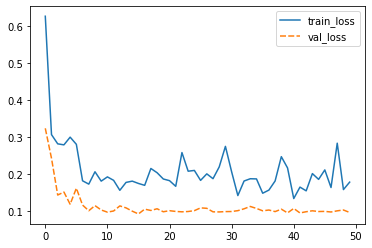

In [11]:
model_conv = torchvision.models.resnet152(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_conv,train_losses,val_losses = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,
                       num_epochs=300)
dump_output(model_conv,train_losses[0:50],val_losses[0:50],'without-pretrained-resnet152_lrscheduler_lastlayer')